# Quantile Random Forest - Smart Meter London

## Objective of this Notebook

- Apply a machine learning algorithm in time series prediction
- Apply rolling forecast

In [ ]:
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 15, 6

from datetime import datetime
import pandas as pd
import numpy as np

# ignore warnings in this demo notebook
import warnings; warnings.simplefilter('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from skgarden import RandomForestQuantileRegressor

from python_code.data_preparation import load_series

## Task Description

### Load Data

You may have to modify the data preparation file (*00_load_smart_meter_data.R*) when applying this code to your own data. In this example, we just have a look at one series, namely the series with id **MAC000002**. We have:

- Number of series: 1
- Date range: 2013-10-30 00:00:00 CET to 2014-02-27 23:00:00 CET (121 days)

In [ ]:
#data_path = '../prepared_data/london_smart_meter/'
data_path = "https://raw.githubusercontent.com/anofox/m3_konferenz/master/prepared_data/london_smart_meter/"
file = 'smart_meters_london_cleaned_same_start_with_weather_example.csv'
params = {'column_sort': 'date_time'}

df = load_series(data_path, file, params)
df.index = df.index.tz_localize('UCT').tz_convert('Etc/GMT-1')

### What is Rolling Forecast?
To achieve a more consistent measure of model performance, we designed a rolling forcast procedure that applies a cross validation logic that accounts for the sequenced nature of the dataset.

This procedure applies two types of forecast: sliding window and expanding window. While both have their applicable use cases, the sliding window form achieves a favorable balance between model accuracy and training time, especially when it comes to testing high frequency data such as daily and hourly time series. The expanding window form, on the other hand, is used more often in weekly, monthly, or quarterly time series where the number of historical points are limited.

Next, we outline how these two types of backtesting can be applied to forecasting:

#### Sliding window
The sliding window method requires three hyperparameters: training window size, forecasting window size (horizon), and sliding steps, detailed below:

- **Training window size**: the number of data points included in a training pass
- **Forecasting window size**: the number of data points to include in forecasting
- **Sliding steps**: the number of data points skipped from one pass to another

![In the sliding window rolling model, a fixed-size training window (in black) slides over the entire history of a time series and is repeatedly tested against a forecasting window (in orange) with older data points dropped.](imgs/image3-4-768x401.png)

#### Expanding window
The expanding window form requires four hyperparameters: starting window size, ending window size, forecasting window size, and expanding steps, outlined below:

- **Starting window size**: the number of data points included in the first training pass
- **Ending window size**: the number of data points included in the last training pass
- **Forecasting window size**: number of data points included for forecasting
- **Expanding steps**: the number of data points added to the training time series from one pass to another

![In the expanding window rolling model, a training window (in black) expands over the entire history of a time series and is repeatedly tested against forecasting window (in orange) without dropping older data points.](imgs/image6-2-768x406.png)

### Parameters

In this experiment we will fit a quantile random forest and perform a one day ahead prediction. A rolling forecast will be performed with 28 days for training. As this experiment shall be compareable to the other experiments, we 2014-01-28 will be the first day of prediction.

In [5]:
h_params = {'n_in': 24 * 28, 'n_out': 24, 'step_foreward': 24, 'column_value': 'energy'}
date_train_start =  datetime.strptime('2013-12-31 00:00:00', '%Y-%m-%d %H:%M:%S')
df = df[df.index >= date_train_start]

# Quantile Random Forest

Random forests were introduced as a machine learning tool in Breiman (2001) and have since proven to be very popular and powerful for high-dimensional regression and classification. For regression, random forests give an accurate approximation of the conditional mean of a response variable. It is shown here that random forests provide information about the full conditional distribution of the response variable, not only about the conditional mean. Conditional quantiles can be inferred with **quantile regression forests**, a generalisation of random forests. **Quantile regression forests** give a non-parametric and accurate way of estimating conditional quantiles for high-dimensional predictor variables. The algorithm is shown to be consistent. Numerical examples suggest that the algorithm is competitive in terms of predictive power.

![Random forest regression](imgs/random_forest.png)

Reference: [Quantile Random Forest](https://scikit-garden.github.io/examples/QuantileRegressionForests/)

## Baseline Model

### Data Preparation

For the first simple model, we add two time features to the data.frame:

- hour and
- weekday

In [6]:
df_energy = df[['energy']]
df_energy['hour'] = df_energy.index.hour
df_energy['weekday'] = df_energy.index.weekday
df_energy.head()

,energy,hour,weekday
date,,,
2013-12-31 00:00:00+01:00,0.888,0,1
2013-12-31 01:00:00+01:00,0.894,1,1
2013-12-31 02:00:00+01:00,0.312,2,1
2013-12-31 03:00:00+01:00,0.219,3,1
2013-12-31 04:00:00+01:00,0.218,4,1


### One day ahead Prediction

Lets do our first prediction.

In [8]:
X_train = df_energy[:h_params['n_in']][['hour', 'weekday']]
y_train = df_energy[:h_params['n_in']][['energy']]
X_train.shape

(672, 2)

In [9]:
rfqr = RandomForestQuantileRegressor(random_state=0)
rfqr.fit(X_train, y_train)
yHat_train = rfqr.predict(X_train)

In [10]:
def smape(yHat, y):
    return np.mean(np.abs((yHat - y) / (y + yHat))) * 100

In [11]:
smape(yHat_train, y_train.values)

35.41292339820931

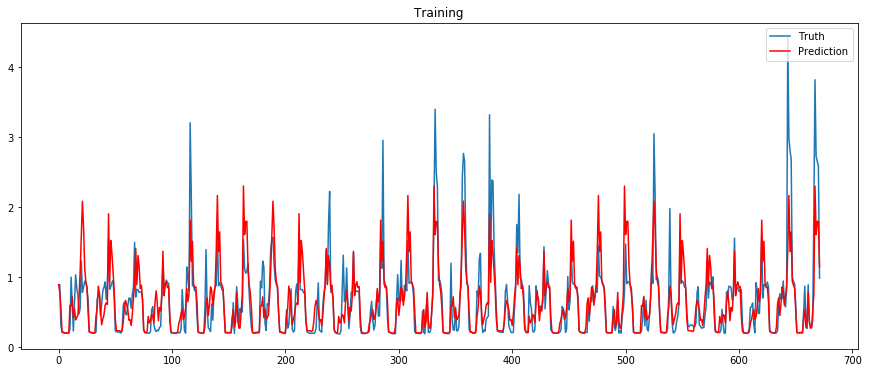

In [12]:
plt.plot(y_train['energy'].values)
plt.plot(yHat_train, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Training")
plt.show()

In [13]:
X_test = df_energy[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['hour', 'weekday']]
y_test = df_energy[h_params['n_in']:(h_params['n_in'] + h_params['n_out'])][['energy']]
yHat_test = rfqr.predict(X_test)
smape(yHat_test, y_test.values)

34.9539533844047

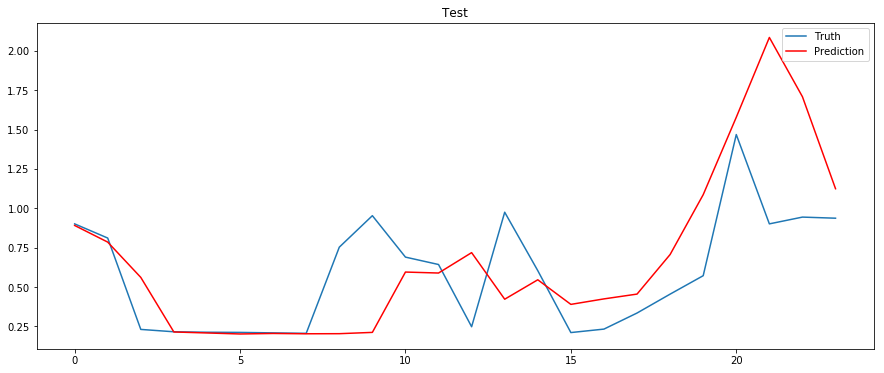

In [14]:
plt.plot(y_test['energy'].values)
plt.plot(yHat_test, color='red')
plt.legend(['Truth', 'Prediction'], loc='upper right')
plt.title("Test")
plt.show()

## Rolling Forecast 

### Data Preparation & Rolling Forecast Helper Functions

Let us write some helper functions that:
1. Create train and test data based on given parameters
2. Perform a rolling forecast experiment with fixed window size

In [15]:
def prepare_train_test(df, y, features, n_in, n_out, current_step, step_foreward):
    step = current_step * step_foreward
    start_train = step
    end_train = n_in + step
    X_train = df[start_train:end_train][features]
    y_train = df[start_train:end_train][y]
    
    start_test = end_train
    end_test = start_test + n_out
    X_test = df[start_test:end_test][features]
    y_test = df[start_test:end_test][y]
    return X_train, y_train, X_test, y_test


def n_possible_steps(df, n_in, n_out, step_foreward):
    timesteps = df.shape[0]
    return int((timesteps - n_in - n_out) / step_foreward)


def rolling_forecast_experiment(df, y, features, n_in, n_out, step_foreward): 
    n_steps = n_possible_steps(df, n_in, n_out, step_foreward)
    
    smape_values = []
    for i in range(0, n_steps):
        rfqr = RandomForestQuantileRegressor(random_state=0)
        X_train, y_train, X_test, y_test = prepare_train_test(df, y, features, n_in, n_out, i, step_foreward)
        rfqr.fit(X_train, y_train)
        yHat = rfqr.predict(X_test)
        smape_values.append(smape(yHat, y_test.values))
    return smape_values

### Simple QRF Model

#### Parameters 
We have by experiment design 30 days to predict. In each of this 30 steps, we will use the 28 days before that day we want to predict as training data. We use **hour** and **weekday** as input features.

In [16]:
# Parameters for rolling forecast
y = ['energy']
features = ['hour', 'weekday']
n_in = h_params['n_in']
n_out = h_params['n_out']

#### Perform Rolling Forecast

Now, everything is prepared for doing a rolling forecast on the last 30 days of our example time series.

In [17]:
smape_values = rolling_forecast_experiment(df_energy, y, features, n_in, n_out, n_out)
np.median(smape_values)

35.48607707481044

We got an median SMPAE value of **35.49%**. We have a lot more attributes in our dataset. Maybe adding them will improve oure forecast.

### Time series Alignment (Optional)

When you change some of this parameters, you have to be cautious, as it will cut-off the end of the series when `(n - n_in - n_out) / step_size` is not an integer. Following function will cut-off the rest term from the beginning of the input series, such that `(n - n_in - n_out) / step_size` is an interger value.

In [18]:
def cut_data_at_start(data, n_in, n_out, step_foreward):
    timesteps = df.shape[0]
    steps = int((timesteps - n_in - n_out) / step_foreward)
    nDrop = timesteps - (steps * n_out + n_in + n_out)
    if nDrop > 0:
        df = df[nDrop:]
    return df

In this case no time series alignement is necessary as experiment parameters and time series length are chosen such that there are no rest terms.

## Multivariate QRF

In this section we add additional to the time related features some weather features. We **assume** in this experiment that the weather features in `X_test` are weather forecasts. This may be not practicable for longer prediction windows.

In [19]:
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df.head()

,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,id,energy,hour,weekday
date,,,,,,,,,,,,
2013-12-31 00:00:00+01:00,11.46,170,6.82,4.94,1012.35,4.62,3.10,0.88,MAC000002,0.888,0,1
2013-12-31 01:00:00+01:00,11.41,162,6.92,5.43,1011.76,4.62,3.29,0.90,MAC000002,0.894,1,1
2013-12-31 02:00:00+01:00,11.57,161,7.50,6.02,1010.82,5.19,3.52,0.90,MAC000002,0.312,2,1
2013-12-31 03:00:00+01:00,11.96,161,8.11,6.31,1009.59,5.92,3.53,0.88,MAC000002,0.219,3,1
2013-12-31 04:00:00+01:00,12.26,161,8.72,7.08,1008.74,6.14,4.63,0.89,MAC000002,0.218,4,1


#### Parameters

Beside **hour** and **weekday**, we added following features to our model:

- visibility
- wind bearing 
- temperature
- dew point
- pressure
- apparent temperature
- wind speed
- humidity

In [20]:
y = ['energy']
features = ['hour', 'weekday', 'visibility', 'windBearing', 'temperature', 'dewPoint', 'pressure', 'apparentTemperature', 'windSpeed', 'humidity']
n_in = h_params['n_in']
n_out = h_params['n_out']

#### Perform Rolling Forecast
The same experiment setup as above is applied, namely performing a rolling forecast on the last 30 days.

In [21]:
smape_values = rolling_forecast_experiment(df, y, features, n_in, n_out, n_out)
np.median(smape_values)

35.01954147672926

Unfortunately, we just have minimal improvement.